In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from scipy import sparse
from scipy.optimize import curve_fit
# specialty code
import cycxchg as cxc

# Load MD Data

In [22]:
# thermodynamic and initial conditions
InitComp = 'C10H16'               # initial molecular composition
Temp = 4000                       # simulation temperature
N = 20800                         # total atoms
Start,End = 0,10                  # in millions of timesteps
run = 1                           # iteration

# location in main_dir
filepath = 'data/C10H16_4000K_bond_data/' # main folder for bond data extracted from ReaxFF simulations

# load data
A            = sparse.load_npz(filepath+'First_Frame.npz')   # adjacency matrix at time 0
atom_types   = np.load(filepath+'atom_types.npy')            # array of atom types carbon (1) hydrogen (2)
is_C         = atom_types == 1                               # as boolean arrays for easy indexing
is_H         = atom_types == 2
Nc = sum(is_C)
Nh = sum(is_H)
# 4 columns in bond change array:   
#   col 0, timestep;   
#   col 1, atom 1;
#   col 2, atom 2;
#   col 3; bond break (0) or form (1)
bond_changes = np.load(filepath+'bond_changes.npy')          
last_step    = bond_changes[-1,0]                  

# make networkx graph
G = nx.Graph(A)
CNodes = [u for u in range(N) if is_C[u]]
Gc=nx.Graph(G.subgraph(CNodes))

# Extract Summary Statistics

Every 1000 timesteps (12ps) from 50,000 to 100,000 collect:

- Minimum cycle bases: random MCB, intersection matrices, cycle length distribution
- `sli` classes:       2D histogram sli class sizes x Cycle lengths, example sli classes
- `pi` classes:        size distribution (num. polyhedra), average number of specific polyhedra

In [ ]:
# sampling parameters
idx = 0         # initial time
cutoff = 50000  # equilibrium time
period = 100    # sampling period (every 10000 for example classes)
# 1 sample at cutoff and at every period steps after
NSamples = 1+(last_step-cutoff)//period

# MCB statistics
max_len = 200
MCB_len_dist = np.zeros((NSamples,max_len))
MCB_list = []
nMCB_vec = np.zeros(NSamples)
# sli statistics
max_sli = 256
sli_SizeXLen_Dist = np.zeros((NSamples,max_sli,max_len))
example_sli = [] # for every 10000
# DICE statistics
max_Poly = 10
pi_nPoly_Dist = np.zeros((NSamples,max_Poly))
num_barallane = np.zeros(NSamples)
num_adamantane = np.zeros(NSamples)
num_iceane = np.zeros(NSamples)
num_twistane = np.zeros(NSamples)
extra=[]

t0 = time.time()
for i,target_idx in enumerate( range(cutoff, last_step, period) ):
    # progress update
    t = time.time()
    print(f'{(target_idx-cutoff)/(last_step-cutoff)*100:4.1f}%   '+
          f'{(t-t0)//3600:2.0f} h {((t-t0)//60)%60:2.0f} m {(t-t0)%60:4.1f} s\r',end='')
    # bring to target_idx
    while bond_changes[idx,0]<target_idx:
        u,v,val=bond_changes[idx,1:]
        # only need carbon skeleton for bicomponent
        if is_C[u] and is_C[v]:
            if val:
                Gc.add_edge(u,v)
            else:
                Gc.remove_edge(u,v)
        idx+=1
                
    # structure relevant cycles
    cyc_dec = cxc.cycle_decomposition(Gc)
    
    # MCB data
    rMCB,Weights,Indices = cyc_dec.random_MCB(merge_MCB=True)
    for C in rMCB:
        MCB_len_dist[i,len(C)]+=1
    MCB_list.append([rMCB,sparse.lil_matrix(Weights),sparse.lil_matrix(Indices)])
    nMCB_vec[i] = cyc_dec.num_MCB()
    
    # sli data
    for sc in cyc_dec.sli_classes:
        sli_SizeXLen_Dist[i,min(sc.num_cycles,max_sli-1),sc.length]+=1
        if sc.num_cycles>1 and (target_idx%10000)==0: 
            example_sli.append(sc)

    # DICE data
    for pc in cyc_dec.pi_classes:
        pi_nPoly_Dist[i,pc.dim_polyhedra]+=1
        if pc.dim_polyhedra>0 and pc.length==6: # sort which poly
            if pc.dim_polyhedra==1:
                # rank is enough to determine the polyhedron if there aren't shorter cycles
                # other structures are rare, and added counts should make this robust
                # can fix using, e.g., an isomorphism test or the full R matrix
                if pc.rank==2 and len(pc.nodes())==8 and pc.num_cycles==3:
                    num_barallane[i]+=1
                elif pc.rank==3 and len(pc.nodes())==10 and pc.num_cycles==4:
                    num_adamantane[i]+=1
                elif pc.rank==4 and len(pc.nodes())==12 and pc.num_cycles==5:
                    num_iceane[i]+=1
                else:
                    extra.append(pc)
            elif pc.dim_polyhedra==2 and pc.rank==3 and len(pc.nodes())==10 and pc.num_cycles==5:
                num_twistane[i]+=1
            else:
                extra.append(pc)

print('\nSampling Complete!      ')

99.8%    1 h 16 m 12.8 s
Sampling Complete!      


### Visual of some `sli` classes
Chosen at random (paper uses `example_sli[11,58,20,164]`)

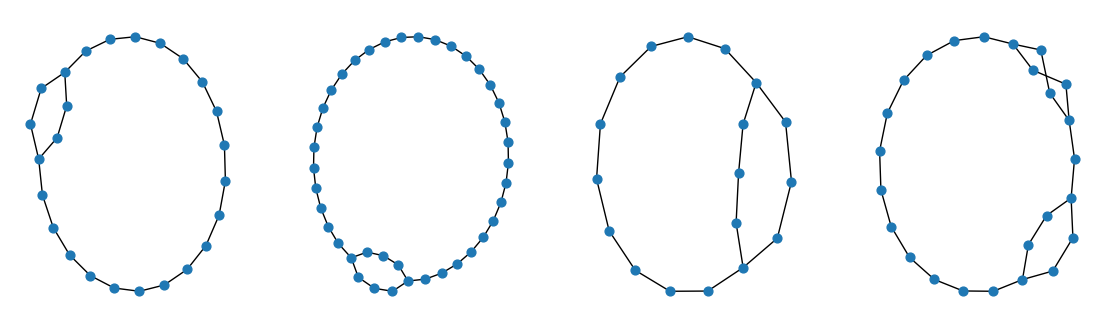

In [56]:
fig,ax = plt.subplots(1,4,figsize=(14,4))
for j in range(4):
    sc = np.random.choice(example_sli)
    nx.draw_kamada_kawai(nx.from_edgelist(sc.edges()),ax=ax[j],node_size=40)

### Size distribution of `sli` classes

/tmp/ipykernel_8733/2231032098.py:8: RuntimeWarning: divide by zero encountered in log10
  hist = ax[1,0].imshow(np.log10(normalize(sli_Hist)),aspect='auto')


[ 0.09223072 -1.35837699]
[ 0.01036236 -0.46580315]


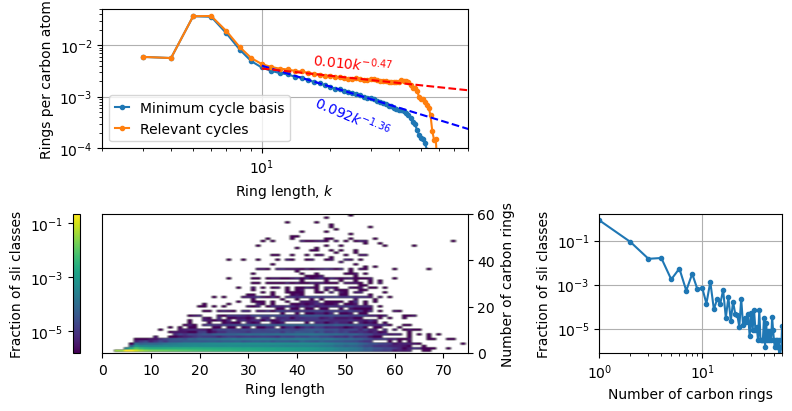

In [59]:
normalize = lambda x: x/np.sum(x)

fig,ax = plt.subplots(2,2,figsize=(8,4), width_ratios=[6,3], layout='constrained')
sli_Hist = np.mean(sli_SizeXLen_Dist,axis=0)
fig.get_layout_engine().set(w_pad=4 / 72*2)

# top-left
hist = ax[1,0].imshow(np.log10(normalize(sli_Hist)),aspect='auto')
ax[1,0].set_ylim([0,60])
ax[1,0].set_xlim([0,75])
ax[1,0].set_xlabel('Ring length')
ax[1,0].set_ylabel('Number of carbon rings')
cbar = fig.colorbar(hist,ax=ax[1,0],label=r'Fraction of sli classes',ticks=[-5,-3,-1],location='left',pad=-.1)
cbar.ax.set_yticklabels([r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$'])
ax[1,0].yaxis.tick_right()
ax[1,0].yaxis.set_label_position("right")

# bottom-left
Nc=8000
ax[0,0].plot(range(3,80),np.mean(MCB_len_dist,axis=0)[3:80]/Nc,'.-')
ax[0,0].plot(range(3,80),(np.arange(max_sli)@sli_Hist)[3:80]/Nc,'.-')
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlim([2,80])
ax[0,0].set_ylim([1e-4,5e-2])
ax[0,0].set_xlabel(r'Ring length, $k$')
ax[0,0].set_ylabel(r'Rings per carbon atom')
ax[0,0].legend(['Minimum cycle basis','Relevant cycles'],handlelength=1)
ax[0,0].grid()

def power_law(x, A, k):
    return A * (x**k)
# add power law fits
p0 = [0.05,-1.5]
xvals = np.logspace(1,2,100)
fit0 = curve_fit(power_law, np.arange(15,40), np.mean(MCB_len_dist,axis=0)[15:40]/Nc,p0)[0]
print(fit0)
ax[0,0].plot(xvals,power_law(xvals,fit0[0],fit0[1]),'b--')
ax[0,0].text(25, power_law(25,fit0[0],fit0[1])*1.05, fr'${fit0[0]:5.3f}k^{{ {fit0[1]:.2f} }}$', 
             horizontalalignment='center', verticalalignment='top',color='blue',rotation=-23)
fit1 = curve_fit(power_law, np.arange(15,40), (np.arange(max_sli)@sli_Hist)[15:40]/Nc,p0)[0]
print(fit1)
ax[0,0].plot(xvals,power_law(xvals,fit1[0],fit1[1]),'r--')
ax[0,0].text(25, power_law(25,fit1[0],fit1[1])*1.05, fr'${fit1[0]:5.3f}k^{{ {fit1[1]:.2f} }}$', 
             horizontalalignment='center', verticalalignment='bottom',color='red',rotation=-6)

# top-right
ax[1,1].plot(range(1,200),normalize(np.sum(sli_Hist,axis=1))[1:200],'.-')
ax[1,1].set_xlim([1,60])
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Number of carbon rings')
ax[1,1].set_ylabel(r'Fraction of sli classes')
ax[1,1].grid()

# clear top right
ax[0,1].set_axis_off()

### Size distribution of `pi` classes

number of pi classes with a polyhedron per atom per time-step: 0.00101


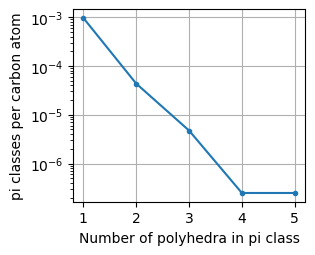

In [63]:
# direct-interchangeability results
plt.figure(figsize=(3,2.5))
Poly_dist = np.mean(pi_nPoly_Dist/Nc,axis=0)
plt.plot(range(1,6),Poly_dist[1:6],'.-')
plt.yscale('log')
plt.ylabel(r'pi classes per carbon atom')
plt.xlabel(r'Number of polyhedra in pi class')

plt.grid()
print(f'number of pi classes with a polyhedron per atom per time-step: {Poly_dist[1:].sum():7.5f}')